In [6]:
import datetime
import os
import random
import pandas as pd
import numpy as np
import operator
import random
from tqdm import tqdm

try:
    import binutil  # required to import from dreamcoder modules
except ModuleNotFoundError:
    import bin.binutil  # alt import if called as module

from dreamcoder.task import Task
from dreamcoder.dreamcoder import *
from dreamcoder.domains.minigrid.primitives import basePrimitives, tmap, taction, idx_to_action, tdirection
from dreamcoder.grammar import Grammar
from dreamcoder.utilities import testTrainSplit, eprint, numberOfCPUs
from dreamcoder.type import arrow
from dreamcoder.domains.minigrid.nn_model_maze import *
from dreamcoder.dreamcoder import commandlineArguments
from dreamcoder.utilities import numberOfCPUs
from bin.maze_T5 import *
import transformers
from transformers import RobertaTokenizer, T5ForConditionalGeneration, AutoTokenizer, TrainingArguments, Seq2SeqTrainer

os.environ["WANDB_PROJECT"] = "T5-Minigrid-Maze"

In [2]:
! ls /home/ma/e/eberhardinger/workspaces/ec/dreamcoder/domains/perfect-maze-minigrid/collected_data/

2022-12-10T15:06:51.671747.npy	2022-12-15T13:34:56.249872.npy
2022-12-10T15:17:43.619183.npy	2022-12-15T14:34:20.172044.npy
2022-12-10T15:26:33.798573.npy	2022-12-15T15:35:54.775637.npy
2022-12-10T15:32:12.354349.npy	2022-12-15T16:35:33.902790.npy
2022-12-13T09:08:03.259228.npy	2022-12-15T17:38:16.683542.npy
2022-12-13T09:19:32.229773.npy	2022-12-15T18:40:13.670383.npy
2022-12-13T09:34:56.104654.npy	2022-12-15T19:43:07.999718.npy
2022-12-13T09:50:53.655924.npy	2022-12-15T20:45:27.107614.npy
2022-12-13T10:46:55.811094.npy	2022-12-15T21:48:05.989464.npy
2022-12-13T11:26:44.661617.npy	2022-12-15T22:48:08.643937.npy
2022-12-13T12:12:33.991250.npy	2022-12-15T23:50:12.515312.npy
2022-12-13T12:57:34.743587.npy	2022-12-16T00:50:54.471201.npy
2022-12-13T13:43:45.232132.npy	2022-12-16T01:52:20.899604.npy
2022-12-13T14:37:17.039305.npy	2022-12-16T02:52:11.339662.npy
2022-12-13T15:34:09.283419.npy	2022-12-16T03:50:00.437851.npy
2022-12-13T16:30:44.111898.npy	2022-12-16T04:48:05.552523.npy
2022-12-

In [12]:
run_name = 'flip-data'
no_spaces = True
compress = False
output_dir = f'/home/ma/e/eberhardinger/workspaces/T5-experimens/{run_name}/'
data_file = "/home/ma/e/eberhardinger/workspaces/ec/dreamcoder/domains/perfect-maze-minigrid/collected_data/2022-12-10T15:32:12.354349.npy"
data = np.load(data_file, allow_pickle=True)
parsed_data = parseData(data)

# we need to call this one time, as otherwise we get parsing errors
grammar = Grammar.uniform(basePrimitives())
checkpoint_dir = get_latest_checkpoint_path(output_dir)
model = T5ForConditionalGeneration.from_pretrained(checkpoint_dir).to('cuda')
tokenizer = RobertaTokenizer.from_pretrained(checkpoint_dir)
collator = LookupTableCollator(tokenizer)
grammar_file = os.path.join(output_dir, 'results.pkl')
with open(grammar_file, 'rb') as handle:
    result = dill.load(handle)
grammar = [g['grammar'] for g in result.values()][-1]
key = list(result.keys())[-1]
print(f'loaded checkpoint from {checkpoint_dir} and grammar from {grammar_file} after sequence length of {key}')

(1163, 6)
loaded checkpoint from /home/ma/e/eberhardinger/workspaces/T5-experimens/flip-data/checkpoint-2000 and grammar from /home/ma/e/eberhardinger/workspaces/T5-experimens/flip-data/results.pkl after sequence length of 59


In [31]:
def makeCompleteSequenceTasks(data):
    keys = data.groups.keys()
    print('keys:', len(keys))
    tasks = []
    for key in keys:
        to_imitate = data.get_group(key)
        examples = []
        part = 0
        for _, row in to_imitate.iterrows():
            input_ex = (row.obs.astype(int).tolist(), int(row['obs direction'],))
            output_ex = int(row.action)
            examples.append((input_ex, output_ex))

        tasks.append(Task(f'perfect maze {key}',
                                 arrow(tmap, tdirection, taction), examples))
    print(f'Created {len(tasks)} tasks')
    return tasks

def makeTasks(data, randomChunkSize=False, fixedChunkSize=5):
    assert randomChunkSize or (not randomChunkSize and fixedChunkSize)
    keys = data.groups.keys()
    print('keys:', len(keys))
    tasks = []
    for key in keys:
        print(key)
        to_imitate = data.get_group(key)
        print(to_imitate)
        if randomChunkSize:
            chunkSize = random.randint(5, 25)
        else:
            chunkSize = fixedChunkSize
        examples = []
        part = 0
        for _, row in to_imitate.iterrows():
            print(row)
            input_ex = ((row.obs[0] * 10).astype(int).tolist(), int(row['obs direction'],))
            output_ex = int(row.action)
            examples.append((input_ex, output_ex))

            if chunkSize > 0 and chunkSize <= len(examples):
                # we check that the chosen actions are not all the same
                # otherwise it is too easy to find a program if all actions/output examples are the same
                # this results in programs such as (lambda (lambda forward-action))
                all_chosen_actions = list(zip(*examples))[1]
                if not all_equal(all_chosen_actions):
                    tasks.append(Task(f'perfect maze {key} size {chunkSize} part {part}', arrow(tmap, tdirection, taction), examples))
                    part += 1
                    # we reset examples and add new chunkSize taskss
                    examples = []
                    if randomChunkSize:
                        chunkSize = random.randint(5, 25)
                    else:
                        chunkSize = fixedChunkSize
        
        if len(examples) > 3:
            all_chosen_actions = list(zip(*examples))[1]
            if not all_equal(all_chosen_actions):
                tasks.append(Task(f'perfect maze {key} size {chunkSize} part {part}', arrow(tmap, tdirection, taction), examples))


In [36]:
tasks = makeCompleteSequenceTasks(parsed_data)
sum_l = sum([int(len(t.examples) / 5) for t in tasks])
for t in tasks:
    print(len(t.examples))
sum_l

keys: 14
Created 14 tasks
131
75
73
61
112
63
145
80
96
80
50
92
87
18


229

In [4]:
with open(grammar_file, 'rb') as handle:
    result = dill.load(handle)
grammar = [g['grammar'] for g in result.values()][-1]
key = list(result.keys())[-1]
print(f'loaded checkpoint from {checkpoint_dir} and grammar from {grammar_file} after sequence length of {key}')

loaded checkpoint from /home/ma/e/eberhardinger/workspaces/T5-experimens/flip-data/checkpoint-1500 and grammar from /home/ma/e/eberhardinger/workspaces/T5-experimens/flip-data/results.pkl after sequence length of 25


In [4]:
def make_task_dict(data, last_key):
    keys = data.groups.keys()
    print('keys:', len(keys))
    tasks = {}
    
    for chunkSize in range(3, int(last_key)+1):
        for key in keys:
            to_imitate = data.get_group(key)
            examples = []
            part = 0
            for _, row in to_imitate.iterrows():
                input_ex = (row.obs.astype(int).tolist(), int(row['obs direction'],))
                output_ex = int(row.action)
                examples.append((input_ex, output_ex))

                if chunkSize <= len(examples):
                    # we check that the chosen actions are not all the same
                    # otherwise it is too easy to find a program if all actions/output examples are the same
                    # this results in programs such as (lambda (lambda forward-action))
                    all_chosen_actions = list(zip(*examples))[1]
                    if not all_equal(all_chosen_actions):
                        task_name = f'perfect maze {key} size {chunkSize} part {part}'
                        tasks[task_name] = Task(task_name,
                                     arrow(tmap, tdirection, taction), examples)
                        part += 1
                        # we reset examples and add new chunkSize taskss
                        examples = []
                
            if len(examples) > 3:
                all_chosen_actions = list(zip(*examples))[1]
                if not all_equal(all_chosen_actions):
                        task_name = f'perfect maze {key} size {chunkSize} part {part}'
                        tasks[task_name] = Task(task_name,
                                     arrow(tmap, tdirection, taction), examples)

    return tasks


def create_dataset(solved_tasks, all_tasks, with_tasks=False, no_spaces=False, compress=False):
    dataset = []
    for task_name, program in solved_tasks:
        task = all_tasks.get(task_name)
        if task is None:
            print(f'{task_name} not found')
            continue
            
        inp_prompt = get_inp_prompt(task, no_spaces, compress)

        if with_tasks:
            dataset.append((inp_prompt, program, task))
        else:
            dataset.append((inp_prompt, program))

    return dataset


def generate_samples_with_temp(txt, n_samples, temp):
    to_tokenizer = [txt for i in range(n_samples)]
    outputs = model.generate(tokenizer(to_tokenizer, return_tensors='pt', padding=True).input_ids.to(
        'cuda'), do_sample=True, max_length=128, temperature=temp)
    results = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    return results

def test_programs_on_task(task, grammar, n=5, temp=1.0, verbose=False):
    progs = generate_samples_with_temp(task[0], n, temp)
    found_progs = []
    for i, prog in enumerate(progs):
        if verbose:
            eprint(prog)
        log_prior = run_on_input_examples(task[1], prog, grammar, verbose=verbose)
        if log_prior is not None:
            found_progs.append((Program.parse(prog), log_prior))

    if len(found_progs) == 0:
        return None, -1

    found_progs.sort(key=lambda x: x[1], reverse=True)

    best = found_progs[0]
    return best[0], best[1]

def check_test_tasks(testTasks, grammar, n_sampling=100, verbose=False):
    stats = []
    solved = 0
    processed = 0
    for tt in (pbar := tqdm(testTasks)):
        p, n = test_programs_on_task(tt, grammar, n=n_sampling, verbose=verbose)
        stats.append((p, tt))
        processed += 1
        if p is not None:
            solved += 1
        pbar.set_description(f"Rate {solved}/{processed}")
    return stats

In [10]:
solved_tasks = np.load(os.path.join(output_dir, 'all_solved_tasks.npy'))
all_tasks = make_task_dict(parsed_data, key)
dataset = create_dataset(solved_tasks, all_tasks, no_spaces=no_spaces, compress=compress)

keys: 14


In [11]:
len(dataset)

4022

In [13]:
finetune_dir = f'{output_dir}finetuning'
os.makedirs(finetune_dir, exist_ok=True)
training_args = TrainingArguments(per_device_train_batch_size=12,
                                  gradient_accumulation_steps=10,
                                  save_steps=500,
                                  save_total_limit=3,
                                  num_train_epochs=10,
                                  output_dir=finetune_dir,
                                  report_to='wandb',
                                  run_name=f'finetune-{run_name}')

dataset = FactoringDataset(dataset)
trainer = Seq2SeqTrainer(model=model, args=training_args, train_dataset=dataset,
                         tokenizer=tokenizer, compute_metrics=None, data_collator=collator)
trainer.train()

PyTorch: setting up devices
/opt/miniconda3/envs/jupyter/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 4022
  Num Epochs = 10
  Instantaneous batch size per device = 12
  Total train batch size (w. parallel, distributed & accumulation) = 120
  Gradient Accumulation steps = 10
  Total optimization steps = 330
  Number of trainable parameters = 60492288
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=330, training_loss=0.0714226347027403, metrics={'train_runtime': 605.2014, 'train_samples_per_second': 66.457, 'train_steps_per_second': 0.545, 'total_flos': 5435056063512576.0, 'train_loss': 0.0714226347027403, 'epoch': 9.98})

In [5]:
def makeTasks(data, chunkSize):
    keys = data.groups.keys()
    print('keys:', len(keys))
    tasks = []
    for key in keys:
        to_imitate = data.get_group(key)
        examples = []
        part = 0
        for _, row in to_imitate.iterrows():
            input_ex = (row.obs.astype(int).tolist(), int(row['obs direction'],))
            output_ex = int(row.action)
            examples.append((input_ex, output_ex))
            if chunkSize > 0 and chunkSize <= len(examples):
                # we check that the chosen actions are not all the same
                # otherwise it is too easy to find a program if all actions/output examples are the same
                # this results in programs such as (lambda (lambda forward-action))
                all_chosen_actions = list(zip(*examples))[1]
                if not all_equal(all_chosen_actions):
                    tasks.append(Task(f'perfect maze {key} size {chunkSize} part {part}',
                                 arrow(tmap, tdirection, taction), examples))
                    part += 1
                    # we reset examples and add new chunkSize taskss
                    examples = []

    print(f'Created {len(tasks)} tasks with {chunkSize} chunk size')
    return tasks

In [ ]:
transformers.logging.set_verbosity_error()

data_file = "/home/ma/e/eberhardinger/workspaces/ec/dreamcoder/domains/perfect-maze-minigrid/collected_data/2022-12-10T15:26:33.798573.npy"
data = np.load(data_file, allow_pickle=True)
parsed_data = parseData(data)

model.eval()
sequence_lengths = reversed(range(5, 40))
solved_tasks = []
for i in sequence_lengths:
    tasks = makeTasks(parsed_data, i)
    testTasks = createTestDataFromTasks(tasks[:100], True, no_spaces=no_spaces, compress=compress)
    stats = check_test_tasks(testTasks, grammar, n_sampling=100, verbose=False)
    solved = [x for x in stats if x[0] is not None]
    solved_tasks += solved
    rate = len(solved)/len(stats) * 100
    print(f'{len(solved)}/{len(stats)} -> {rate}%')
    np.save(os.path.join(finetune_dir, 'all_solved_tasks_10epochs.npy'), np.array(solved_tasks))

(1721, 6)
keys: 18
Created 34 tasks with 39 chunk size


Rate 0/34: 100%|██████████| 34/34 [04:32<00:00,  8.03s/it]


0/34 -> 0.0%
keys: 18
Created 34 tasks with 38 chunk size


Rate 0/34: 100%|██████████| 34/34 [04:32<00:00,  8.02s/it]


0/34 -> 0.0%
keys: 18
Created 36 tasks with 37 chunk size


Rate 0/36: 100%|██████████| 36/36 [04:42<00:00,  7.83s/it]


0/36 -> 0.0%
keys: 18
Created 39 tasks with 36 chunk size


Rate 0/39: 100%|██████████| 39/39 [04:59<00:00,  7.67s/it]


0/39 -> 0.0%
keys: 18
Created 41 tasks with 35 chunk size


Rate 0/41: 100%|██████████| 41/41 [05:16<00:00,  7.71s/it]


0/41 -> 0.0%
keys: 18
Created 42 tasks with 34 chunk size


Rate 0/42: 100%|██████████| 42/42 [05:11<00:00,  7.41s/it]


0/42 -> 0.0%
keys: 18
Created 45 tasks with 33 chunk size


Rate 0/45: 100%|██████████| 45/45 [05:37<00:00,  7.49s/it]


0/45 -> 0.0%
keys: 18
Created 47 tasks with 32 chunk size


Rate 0/47: 100%|██████████| 47/47 [05:40<00:00,  7.24s/it]


0/47 -> 0.0%
keys: 18
Created 47 tasks with 31 chunk size


Rate 0/47: 100%|██████████| 47/47 [05:45<00:00,  7.36s/it]


0/47 -> 0.0%
keys: 18
Created 48 tasks with 30 chunk size


Rate 0/48: 100%|██████████| 48/48 [05:48<00:00,  7.25s/it]


0/48 -> 0.0%
keys: 18
Created 51 tasks with 29 chunk size


Rate 1/51: 100%|██████████| 51/51 [06:09<00:00,  7.24s/it]
/tmp/ipykernel_2217571/3109099845.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save(os.path.join(finetune_dir, 'all_solved_tasks_10epochs.npy'), np.array(solved_tasks))


1/51 -> 1.9607843137254901%
keys: 18
Created 52 tasks with 28 chunk size


Rate 0/52: 100%|██████████| 52/52 [06:10<00:00,  7.13s/it]


0/52 -> 0.0%
keys: 18
Created 54 tasks with 27 chunk size


Rate 1/54: 100%|██████████| 54/54 [06:20<00:00,  7.04s/it]


1/54 -> 1.8518518518518516%
keys: 18
Created 60 tasks with 26 chunk size


Rate 1/60: 100%|██████████| 60/60 [06:57<00:00,  6.95s/it]


1/60 -> 1.6666666666666667%
keys: 18
Created 61 tasks with 25 chunk size


Rate 1/61: 100%|██████████| 61/61 [06:58<00:00,  6.86s/it]


1/61 -> 1.639344262295082%
keys: 18
Created 63 tasks with 24 chunk size


Rate 1/63: 100%|██████████| 63/63 [07:11<00:00,  6.85s/it]


1/63 -> 1.5873015873015872%
keys: 18
Created 63 tasks with 23 chunk size


Rate 2/63: 100%|██████████| 63/63 [07:10<00:00,  6.83s/it]


2/63 -> 3.1746031746031744%
keys: 18
Created 70 tasks with 22 chunk size


Rate 2/70: 100%|██████████| 70/70 [07:47<00:00,  6.68s/it]


2/70 -> 2.857142857142857%
keys: 18
Created 76 tasks with 21 chunk size


Rate 12/100: 100%|██████████| 100/100 [10:26<00:00,  6.26s/it]


12/100 -> 12.0%
keys: 18
Created 106 tasks with 15 chunk size


Rate 15/100: 100%|██████████| 100/100 [10:30<00:00,  6.30s/it]


15/100 -> 15.0%
keys: 18
Created 114 tasks with 14 chunk size


Rate 19/100: 100%|██████████| 100/100 [10:22<00:00,  6.23s/it]


19/100 -> 19.0%
keys: 18
Created 125 tasks with 13 chunk size


Rate 21/100: 100%|██████████| 100/100 [10:18<00:00,  6.19s/it]


21/100 -> 21.0%
keys: 18
Created 135 tasks with 12 chunk size


Rate 11/71:  71%|███████   | 71/100 [07:12<03:07,  6.48s/it]#(lambda (lambda (#(lambda (if $0 left-action forward-action)) (eq-obj? (get $1 2 1) $0)))) Not in candidates
Candidates is {#(lambda (lambda (#(lambda (#(lambda (if $0 left-action forward-action)) (eq-obj? wall-obj $0))) (get $0 $1 1)))): (-0.4274440148269396, int -> array(array(tobj)) -> taction, Context(next = 0, {})), #(lambda (lambda (#(lambda (lambda (lambda (#(lambda (lambda (#(lambda (if $0 left-action forward-action)) (eq-obj? (#(lambda (get $0 2 1)) $1) $0)))) $2 (get $0 $1 4))))) $0 1 $1))): (-0.4274440148269396, array(array(tobj)) -> array(array(tobj)) -> taction, Context(next = 0, {})), #(lambda (#(lambda (if (not (eq-obj? wall-obj ($0 #(lambda (get $0 2 1))))) forward-action left-action)) (lambda (get $1 2 1)))): (-0.4274440148269396, array(array(tobj)) -> taction, Context(next = 0, {})), #(lambda (#(lambda (lambda (#(lambda (lambda (if (not (eq-obj? $0 $1)) forward-action left-action))) (#(lambda (get $0 2 1)) $

19/100 -> 19.0%
keys: 18
Created 150 tasks with 11 chunk size


Rate 28/100: 100%|██████████| 100/100 [10:01<00:00,  6.01s/it]


28/100 -> 28.000000000000004%
keys: 18
Created 163 tasks with 10 chunk size


Rate 14/51:  51%|█████     | 51/100 [05:05<04:53,  5.99s/it]#(lambda (#(lambda (if $0 forward-action left-action)) (eq-obj? wall-obj (get $0 2 1)))) Not in candidates
Candidates is {#(lambda (lambda (#(lambda (#(lambda (if $0 left-action forward-action)) (eq-obj? wall-obj $0))) (get $0 $1 1)))): (-0.4274440148269396, int -> array(array(tobj)) -> taction, Context(next = 1, {t0 ||> taction})), #(lambda (lambda (#(lambda (lambda (lambda (#(lambda (lambda (#(lambda (if $0 left-action forward-action)) (eq-obj? (#(lambda (get $0 2 1)) $1) $0)))) $2 (get $0 $1 4))))) $0 1 $1))): (-0.4274440148269396, array(array(tobj)) -> array(array(tobj)) -> taction, Context(next = 1, {t0 ||> taction})), #(lambda (#(lambda (if (not (eq-obj? wall-obj ($0 #(lambda (get $0 2 1))))) forward-action left-action)) (lambda (get $1 2 1)))): (-0.4274440148269396, array(array(tobj)) -> taction, Context(next = 1, {t0 ||> taction})), #(lambda (#(lambda (lambda (#(lambda (lambda (if (not (eq-obj? $0 $1)) forward-action l

In [3]:
run_name = 'flip-data'
no_spaces = True
compress = False
output_dir = f'/home/ma/e/eberhardinger/workspaces/T5-experimens/{run_name}/'
finetune_dir = f'{output_dir}finetuning'
solved_stats = np.load(os.path.join(finetune_dir, 'all_solved_tasks_10epochs.npy'), allow_pickle=True)

In [4]:
def map_stats_to_len(stats):
    mapping = {}
    for stat in solved_stats:
        l = len(stat[1][1].examples)
        if l not in mapping:
            mapping[l] = []
        mapping[l].append(stat)
    return mapping

solved_stats_dict = map_stats_to_len(solved_stats)

In [25]:
transformers.logging.set_verbosity_error()

data_file = "/home/ma/e/eberhardinger/workspaces/ec/dreamcoder/domains/perfect-maze-minigrid/collected_data/2022-12-10T15:26:33.798573.npy"
data = np.load(data_file, allow_pickle=True)
parsed_data = parseData(data)

sequence_lengths = range(5, 31)
solved_tasks = []
for i in sequence_lengths:
    tasks = makeTasks(parsed_data, i)
    testTasks = createTestDataFromTasks(tasks, True, no_spaces=no_spaces, compress=compress)
    num_tasks = len(testTasks)
    solved = len(solved_stats_dict.get(i, []))
    rate = solved/len(testTasks) * 100
    print(f'{solved}/{len(testTasks)} -> {rate}%')
    solved_tasks.append({
        'solved': solved,
        'tasks': len(testTasks),
        'rate': rate
    })
df = pd.DataFrame(solved_tasks, index=sequence_lengths)

(1721, 6)
keys: 18
Created 320 tasks with 5 chunk size
78/100 -> 78.0%
keys: 18
Created 274 tasks with 6 chunk size
73/100 -> 73.0%
keys: 18
Created 237 tasks with 7 chunk size
64/100 -> 64.0%
keys: 18
Created 206 tasks with 8 chunk size
50/100 -> 50.0%
keys: 18
Created 181 tasks with 9 chunk size
42/100 -> 42.0%
keys: 18
Created 163 tasks with 10 chunk size
36/100 -> 36.0%
keys: 18
Created 150 tasks with 11 chunk size
30/100 -> 30.0%
keys: 18
Created 135 tasks with 12 chunk size
20/100 -> 20.0%
keys: 18
Created 125 tasks with 13 chunk size
23/100 -> 23.0%
keys: 18
Created 114 tasks with 14 chunk size
20/100 -> 20.0%
keys: 18
Created 106 tasks with 15 chunk size
16/100 -> 16.0%
keys: 18
Created 100 tasks with 16 chunk size
12/100 -> 12.0%
keys: 18
Created 92 tasks with 17 chunk size
7/92 -> 7.608695652173914%
keys: 18
Created 87 tasks with 18 chunk size
7/87 -> 8.045977011494253%
keys: 18
Created 80 tasks with 19 chunk size
8/80 -> 10.0%
keys: 18
Created 78 tasks with 20 chunk size
4/7

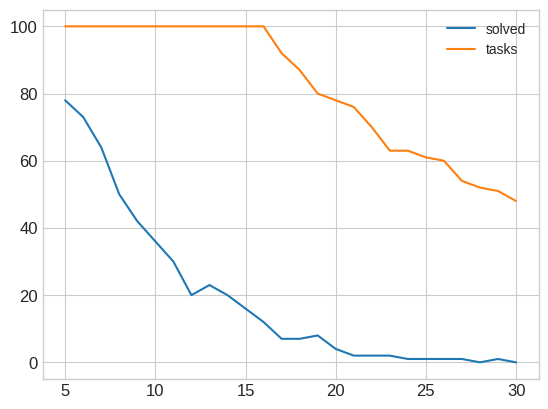

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
df[['solved', 'tasks']].plot(kind='line')
plt.show()


In [9]:
obs = eval('[(([[2, 2, 2, 2, 2], [2, 2, 2, 2, 2], [1, 2, 2, 2, 2], [1, 2, 2, 2, 2], [1, 2, 2, 2, 2]], 0), 0), (([[1, 2, 2, 2, 2], [2, 2, 2, 2, 2], [1, 2, 2, 2, 2], [2, 2, 2, 2, 2], [2, 2, 2, 2, 2]], 3), 0), (([[1, 1, 1, 2, 1], [1, 2, 1, 2, 2], [1, 2, 1, 1, 1], [2, 2, 2, 2, 2], [2, 2, 2, 2, 2]], 2), 0), (([[2, 2, 2, 2, 2], [2, 2, 2, 2, 2], [1, 1, 1, 1, 1], [2, 2, 1, 2, 2], [1, 1, 1, 2, 1]], 1), 2), (([[2, 2, 2, 2, 2], [2, 2, 2, 2, 2], [1, 1, 1, 1, 1], [2, 1, 2, 2, 2], [1, 1, 2, 1, 1]], 1), 2), (([[2, 2, 2, 2, 2], [2, 2, 2, 2, 2], [1, 1, 1, 1, 1], [1, 2, 2, 2, 1], [1, 2, 1, 1, 1]], 1), 2), (([[2, 2, 2, 2, 2], [2, 2, 2, 2, 2], [1, 1, 1, 1, 1], [2, 2, 2, 1, 2], [2, 1, 1, 1, 2]], 1), 2), (([[2, 2, 2, 2, 2], [2, 2, 2, 2, 2], [1, 1, 1, 1, 1], [2, 2, 1, 2, 1], [1, 1, 1, 2, 1]], 1), 2), (([[2, 2, 2, 2, 2], [2, 2, 2, 2, 2], [1, 1, 1, 1, 1], [2, 1, 2, 1, 2], [1, 1, 2, 1, 1]], 1), 2), (([[2, 2, 2, 2, 2], [2, 2, 2, 2, 2], [1, 1, 1, 1, 1], [1, 2, 1, 2, 2], [1, 2, 1, 1, 1]], 1), 2), (([[2, 2, 2, 2, 2], [2, 2, 2, 2, 2], [1, 1, 1, 1, 1], [2, 1, 2, 2, 2], [2, 1, 1, 1, 2]], 1), 2), (([[2, 2, 2, 2, 2], [2, 2, 2, 2, 2], [1, 1, 1, 1, 1], [1, 2, 2, 2, 1], [1, 1, 1, 2, 1]], 1), 2), (([[2, 2, 2, 2, 2], [2, 2, 2, 2, 2], [1, 1, 1, 1, 1], [2, 2, 2, 1, 2], [1, 1, 2, 1, 2]], 1), 2), (([[2, 2, 2, 2, 2], [2, 2, 2, 2, 2], [1, 1, 1, 1, 1], [2, 2, 1, 2, 1], [1, 2, 1, 2, 1]], 1), 2), (([[2, 2, 2, 2, 2], [2, 2, 2, 2, 2], [1, 1, 1, 1, 1], [2, 1, 2, 1, 2], [2, 1, 2, 1, 1]], 1), 2), (([[2, 2, 2, 2, 2], [2, 2, 2, 2, 2], [1, 1, 1, 1, 1], [1, 2, 1, 2, 2], [1, 2, 1, 1, 1]], 1), 2), (([[2, 2, 2, 2, 2], [2, 2, 2, 2, 2], [1, 1, 1, 1, 2], [2, 1, 2, 2, 2], [2, 1, 1, 1, 1]], 1), 2), (([[2, 2, 2, 2, 2], [2, 2, 2, 2, 2], [1, 1, 1, 2, 8], [1, 2, 2, 2, 1], [1, 1, 1, 1, 1]], 1), 2), (([[2, 2, 2, 2, 2], [2, 2, 2, 2, 2], [1, 1, 2, 8, 2], [2, 2, 2, 1, 2], [1, 1, 1, 1, 2]], 1), 2), (([[2, 2, 2, 2, 2], [2, 2, 2, 2, 2], [1, 2, 8, 2, 2], [2, 2, 1, 2, 2], [1, 1, 1, 2, 2]], 1), 0)]')

In [25]:
solved_stats_dict.get(20)

[array([(lambda (lambda (#(lambda (lambda (if (not (eq-obj? (get $1 2 $0) wall-obj)) forward-action left-action))) $1 1))),
        ('22222222221222212222122220 a 12222222221222222222222223 a 11121121221211122222222222 a 22222222221111122122111211 c 22222222221111121222112111 c 22222222221111112221121111 c 22222222221111122212211121 c 22222222221111122121111211 c 22222222221111121212112111 c 22222222221111112122121111 c 22222222221111121222211121 c 22222222221111112221111211 c 22222222221111122212112121 c 22222222221111122121121211 c 22222222221111121212212111 c 22222222221111112122121111 c 22222222221111221222211111 c 22222222221112812221111111 c 22222222221128222212111121 c 22222222221282222122111221 a', Task(name=perfect maze 12 size 20 part 0, request=array(array(tobj)) -> tdirection -> taction, examples=[(([[2, 2, 2, 2, 2], [2, 2, 2, 2, 2], [1, 2, 2, 2, 2], [1, 2, 2, 2, 2], [1, 2, 2, 2, 2]], 0), 0), (([[1, 2, 2, 2, 2], [2, 2, 2, 2, 2], [1, 2, 2, 2, 2], [2, 2, 2, 2, 2], [2, 2, 2, 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
enum = pd.read_csv('/home/ma/e/eberhardinger/workspaces/ec/eval_enum_search.csv', index_col=0)
libt5= pd.read_csv('/home/ma/e/eberhardinger/workspaces/T5-experimens/flip-data/eval.csv', index_col=0)
nolib=pd.read_csv('/home/ma/e/eberhardinger/workspaces/T5-experimens/no-lib-learning/eval.csv', index_col=0)
nnsearch=pd.read_csv('/home/ma/e/eberhardinger/workspaces/ec/eval_neural-guided_search.csv', index_col=0)
libfixed = pd.read_csv('/home/ma/e/eberhardinger/workspaces/T5-experimens/fix-test-collator-less-tasks/eval.csv', index_col=0)
normed = pd.DataFrame(enum.solved/ enum.tasks, columns=["DreamCoder"])
normed['Enumerative Search'] = nnsearch.solved / enum.tasks
normed['CodeT5'] = nolib.solved / enum.tasks
normed['LibT5'] = libt5.solved / enum.tasks
normed['Fixed'] = libfixed.solved / enum.tasks
normed = normed.fillna(0.0)
normed

,DreamCoder,Enumerative Search,CodeT5,LibT5,Fixed
5,0.225000,0.225000,0.590625,0.850000,0.696875
6,0.145985,0.145985,0.474453,0.788321,0.664234
7,0.101266,0.101266,0.396624,0.713080,0.594937
8,0.033981,0.033981,0.315534,0.626214,0.509709
9,0.055249,0.055249,0.325967,0.580110,0.491713
10,0.030675,0.030675,0.245399,0.478528,0.368098
11,0.026667,0.026667,0.213333,0.460000,0.306667
12,0.007407,0.007407,0.148148,0.333333,0.296296
13,0.016000,0.016000,0.160000,0.304000,0.256000
14,0.008772,0.008772,0.149123,0.236842,0.210526


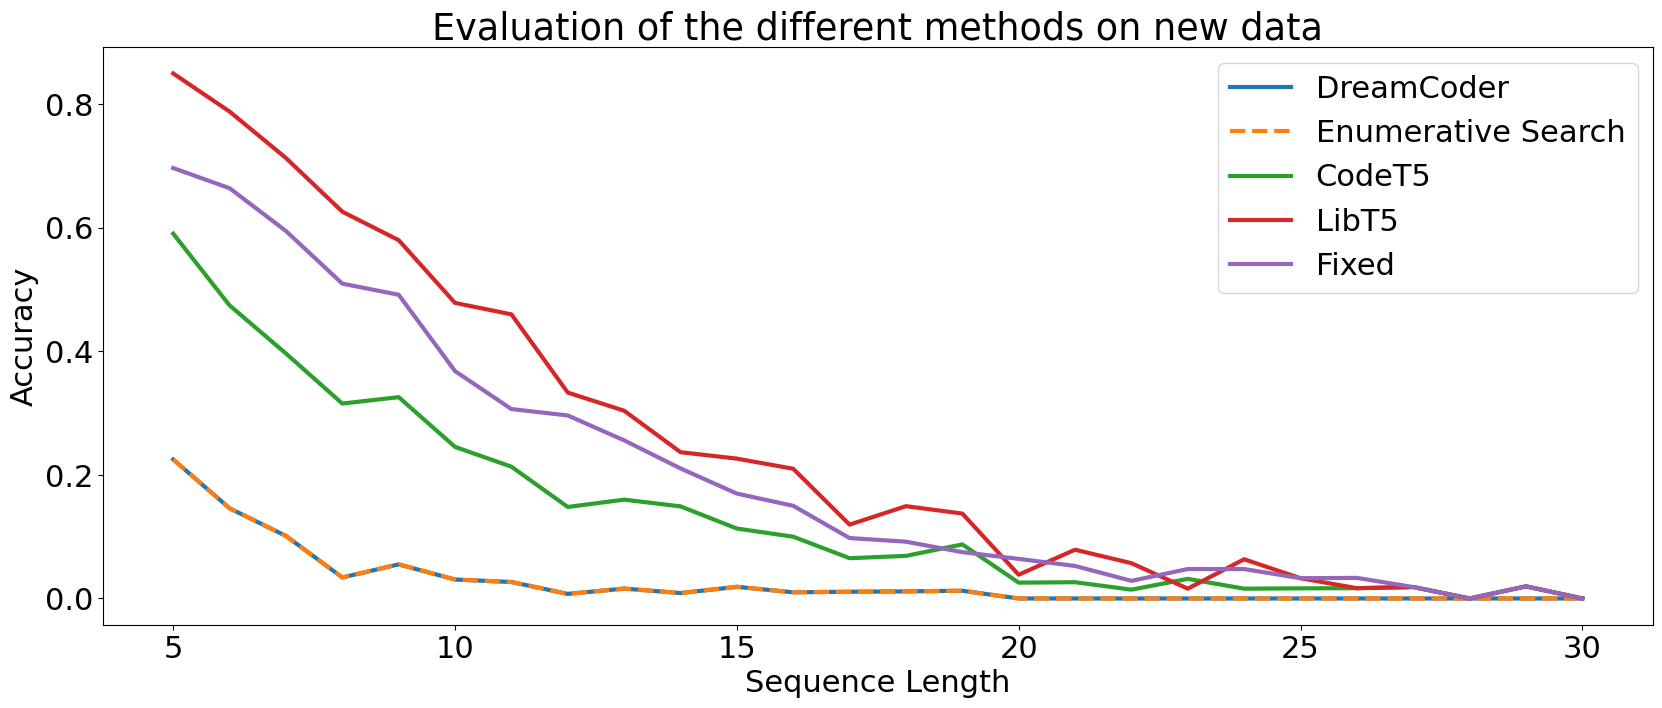

In [3]:
font = {'size'   : 22}

plt.rc('font', **font)
normed.plot(kind='line', figsize=(20,7.5), xlabel="Sequence Length", ylabel="Accuracy", title="Evaluation of the different methods on new data", style=['-','--','-', '-'], linewidth=3)
plt.savefig("eval.pdf", format="pdf")

In [9]:
pd.read_csv('/home/ma/e/eberhardinger/workspaces/T5-experimens/no-lib-learning/eval.csv', index_col=0)

,solved,tasks
5,189,320
6,130,274
7,94,237
8,65,206
9,59,181
10,40,163
11,32,150
12,20,135
13,20,125
14,17,114


In [6]:
nnsearch

,solved,tasks
5,72,320
6,40,274
7,24,237
8,7,206
9,10,181
10,5,163
11,4,150
12,1,135
13,2,125
14,1,114
